In [295]:
%pylab inline
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = (10,8)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd

/home/coda/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
import numpy as np

In [4]:
# Define function to compute saturation vapor pressure in Pa, given temperature in C.
def esat(TC):
    return(611.2*np.exp(17.67*TC/(TC+243.5)))

#=================

# Define function to compute saturation mixing ratio, given temperature in K and pressure in Pa
def wsat(TK,p):
    es = esat(TK-273.15)
    return(0.622*es/(p-es))

In [5]:
from scipy.constants import g, C2K, K2C

In [6]:
import weight_shell

In [7]:
sonde = weight_shell.read_sonde('91408_2011_07_19_12.txt')
levels = weight_shell.interpolate_sounding(sonde)
Atmosphere = weight_shell.create_atmosphere(levels)

Successfully opened file  91408_2011_07_19_12.txt
93  levels in raw input sounding
269  levels in interpolated sounding
    p [Pa]    T [C] Td [C]  T [K]     q []
268  layers in model atmosphere
Total precipitable water =  57.7460405625  kg/m^2


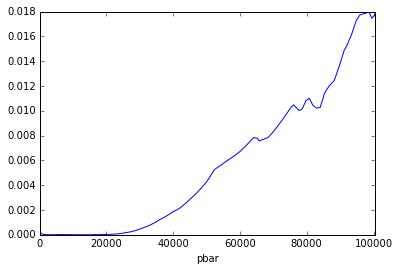

In [8]:
atmos = (pd.DataFrame(
        [{key:getattr(x, key) for key in ['pbar','Tbar','rho','rhowv','DZ','qbar','mass','wvmass']}
         for x in Atmosphere])
         .set_index('pbar', drop=False).sort_index())
atmos.qbar.plot()

In [9]:
atmos['Zbar'] = atmos.set_index('pbar').sort_index(ascending=False).DZ.cumsum()

In [231]:
def get_weighting_function_upwelling(f, layers, mu=1.):
    import gasabsr98
    layers['ke_air'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[0], axis=1)
    layers['ke_wv'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[1], axis=1)
    
    layers['tau'] = (layers.ke_air*(layers.mass - layers.wvmass) + layers.ke_wv*layers.wvmass)
    layers = layers.reset_index(drop=True)
    layers['tx_from_top'] = (layers
                    # Take tau(z)
                     .sort_values('Zbar', ascending=False).tau
                    # Compute total optical depths from toa to z for each z
                     .cumsum()
                    # Compute tx = e^(-tau/mu)
                    .apply(lambda tau: np.exp(-tau/mu)))
    
    # Compute the contribution from each layer
    layers['layer_weight'] = -(layers.sort_values('Zbar', ascending=False).tx_from_top.diff())
    
    # Get weight for each layer in m^-1
    layers['weighting_function'] = layers.layer_weight / layers.sort_values('Zbar', ascending=True).Zbar.diff() * 1000
    return layers

In [254]:
def get_weighting_function_downwelling(f, layers, mu=1):
    import gasabsr98
    layers['ke_air'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[0], axis=1)
    layers['ke_wv'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[1], axis=1)
    
    layers['tau'] = (layers.ke_air*(layers.mass - layers.wvmass) + layers.ke_wv*layers.wvmass)
    layers = layers.reset_index(drop=True)
    layers['tx_from_bottom'] = (layers
                    # Take tau(z)
                     .sort_values('Zbar', ascending=True).tau
                    # Compute total optical depths from toa to z for each z
                     .cumsum()
                    # Compute tx = e^(-tau/mu)
                    .apply(lambda tau: np.exp(-tau/mu)))
    
    # Compute the contribution from each layer
    layers['layer_weight'] = (layers.sort_values('Zbar', ascending=False).tx_from_bottom.diff())
    
    # Get weight for each layer in m^-1
    layers['weighting_function'] = layers.layer_weight / -layers.sort_values('Zbar', ascending=False).Zbar.diff() * 1000
    return layers
    #     return -(-layers.set_index('Zbar')
#              .tau
#              .sort_index(ascending=False)
#              .cumsum()).apply(np.exp).sort_index(ascending=True).diff().dropna() / layers.set_index('Zbar').DZ * 1000
#    return (-(-atmos.set_index('Zbar').tau.sort_index(ascending=True).cumsum()).apply(np.exp).sort_index(ascending=True).diff().dropna()/ atmos.set_index('Zbar').DZ* 1000)

In [305]:
def get_weighting_function_satellite(f, layers, surf_emis, mu=1):
    refl = 1.0-surf_emis
    down = get_weighting_function_downwelling(f, layers, mu).set_index('Zbar').ix[:, ('weighting_function','layer_weight','tx_from_bottom')]
    up = get_weighting_function_upwelling(f, layers, mu).set_index('Zbar').ix[:,('weighting_function', 'layer_weight','tx_from_top')]
    both = down*refl*up.tx_from_top.min() + up
    both['tx_from_top'] = up.tx_from_top
    both['tx_from_bottom'] = down.tx_from_bottom
    return both
    

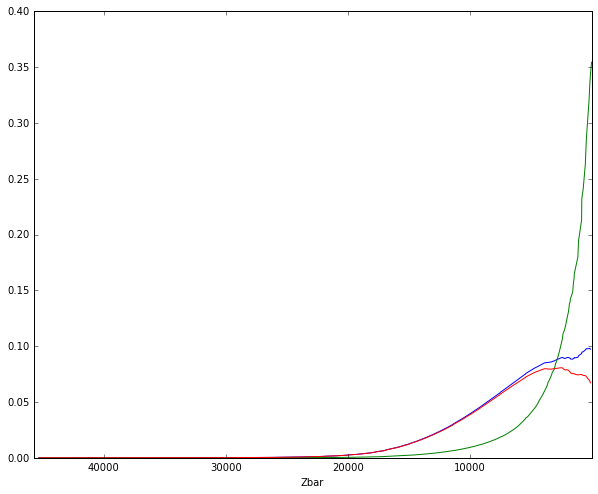

In [306]:
get_weighting_function_satellite(53.3, atmos, .5).weighting_function.plot()
get_weighting_function_downwelling(53.3, atmos).set_index('Zbar').weighting_function.plot()
get_weighting_function_upwelling(53.3, atmos).set_index('Zbar').weighting_function.plot()

In [307]:
amsu_a = pd.Series(
    {
        3:  50.3000,
        4:  52.8000,
        5:  53.7110,
        6:  54.4000,
        7:  54.9400,
        8:  55.5000,
        9:  57.2900,
        10: 57.5070
    }
)

amsu_b = pd.Series(
    {
       16: 89.00,
        17: 150.0,
        18: 184.31,
        19: 186.31,
        20: 190.31
    }
)

In [308]:
weighting_functions_a = pd.DataFrame({ channel:get_weighting_function_satellite(amsu_a[channel], atmos, .0001).weighting_function for channel in amsu_a.index})
weighting_functions_b = pd.DataFrame({ channel:get_weighting_function_satellite(amsu_b[channel], atmos, .0001).weighting_function for channel in amsu_b.index})

(0, 0.12)

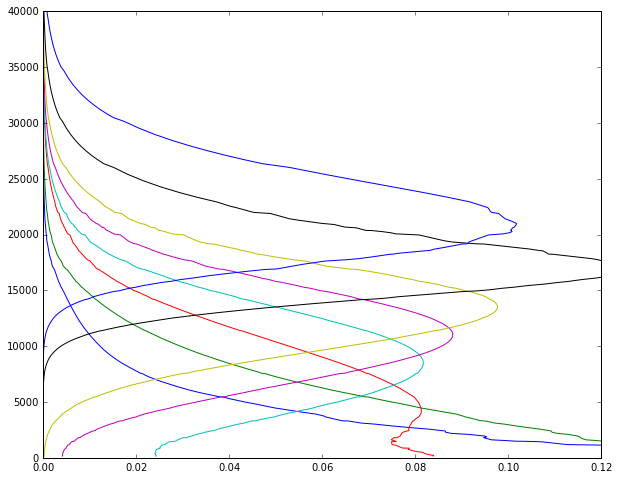

In [309]:
plot(weighting_functions_a.values, weighting_functions_a.index)
#plot(weighting_functions_b, weighting_functions_b.index)
#legend(amsu_a.index, loc='best')
ylim([0,40000])
xlim([0,.12])

In [326]:
for x in amsu_a.values:
    print (get_weighting_function_satellite(x, atmos, .5, .5).tx_from_top.min()*300 * .5
 +(get_weighting_function_satellite(x, atmos, .5, .5).layer_weight * atmos.set_index('Zbar').Tbar).sum()
)

258.945466376
261.247014099
243.017649977
228.135129378
216.258059192
207.664355839
206.208878258
213.829450754


In [34]:
(1-(weighting_functions_a[3]))
#atmos.set_index('Zbar').DZ.iloc[0]/1000

Zbar
61.868370       4.833019e+09
150.872940      9.126455e-01
210.483012      9.106449e-01
270.385633      9.106139e-01
377.871718      9.106741e-01
486.331814      9.108378e-01
574.950996      9.126250e-01
746.829312      9.175536e-01
860.381172      9.217354e-01
878.468968      9.231168e-01
1130.300525     9.285224e-01
1183.200708     9.337435e-01
1437.897510     9.361801e-01
1478.256068     9.389690e-01
1488.361410     9.398881e-01
1549.134532     9.407848e-01
1610.143883     9.423296e-01
1793.408671     9.432021e-01
1805.903843     9.433651e-01
1879.079663     9.429318e-01
1952.727945     9.419605e-01
2098.368944     9.431422e-01
2187.615066     9.457757e-01
2294.551844     9.466583e-01
2402.652071     9.464767e-01
2439.134134     9.463145e-01
2572.920129     9.473425e-01
2708.499485     9.494744e-01
2859.786261     9.516279e-01
3013.412764     9.537944e-01
                    ...     
32024.749784    9.999901e-01
32477.129693    9.999914e-01
32963.964348    9.999926e-01
33490.866